# Comparing Regression Algorithms - Part 3, Machine Learning

### Machine Learning

In computer science, we try to make algorithms faster. There are several ways we can get a speedup:

- Rewrite our algorithm so that it's faster
- Use technology that allows us to do more than one computation at once (parallelization)
- Use technology specifically designed to perform the types of calculations we need faster (specialization)

For this notebook, we will be using Google's TensorFlow machine learning toolkit. To install the TensorFlow package, open a terminal and type:

`pip install --upgrade tensorflow`

You will not need TensorFlow until you get to the bottom of this notebook.

### Stuff from last time

Let's get the most useful functions from the previous notebook. When you run this cell, it will randomly generate lists of x and y values. In addition, it will use [`numpy`'s built in least squares algorithm](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html), which runs very quickly, to generate some actual numbers with which we can make comparisons.

In [69]:
import numpy as np
import time

cheat_W = 2
cheat_b = -4

starting_value = 2
ending_value = 8
num_values = 40

def make_vals(starting_value, ending_value, num_values):
    # Let's make a bunch of x values
    x_vals = np.linspace(starting_value, ending_value, num_values)
    # Let's make a bunch of y values close to our equation, but randomly off by a small amount
    noise = np.random.uniform(-1, 1, 40)
    target_loss = np.sum(np.square(noise))
    y_vals = cheat_W * x_vals + cheat_b + noise
    return x_vals, y_vals, abs(target_loss)

def measure_time(algorithm, steps):
    start = time.time()
    algorithm(steps)
    return time.time() - start

def generate_plane(a, b, c, noise):
    # Make an array of tuples of (x, y, z)
    coords = [(x , y, (a * x + b * y) / -c) for x in np.linspace(0, 10, 20) for y in np.linspace(0, 10, 20) ]
    # Return the "unzipped" tuples in 3 separate arrays
    x_vals, y_vals, z_vals = zip(*coords)
    x_vals = np.asarray(x_vals)
    y_vals = np.asarray(y_vals)
    z_vals = np.asarray(z_vals)
    # Add some noise to z
    noise_vals = np.random.uniform(-noise, noise, len(x_vals))
    actual_loss = np.sum(np.square(noise_vals))
    z_vals += noise_vals
    return x_vals, y_vals, z_vals, actual_loss

x_vals, y_vals, actual_loss = make_vals(starting_value, ending_value, num_values)

# Let's cheat again, and use numpy's built in linear regression
start = time.time()
actual_W, actual_b = np.linalg.lstsq(np.vstack([x_vals, np.ones(len(x_vals))]).T, y_vals)[0]
print "Cheating time:", time.time() - start

print "Actual loss:", actual_loss
print "Actual W:", target_W
print "Actual b:", target_b

Cheating time: 0.000856876373291
Actual loss: 13.4282295595
Actual W: 1.96799394994
Actual b: -3.75563115821


### TensorFlow

Let's rewrite our regression algorithm to use machine learning to perform the regression. We will use Google's TensorFlow package. First, we will create the variables for `W` and `b`, that we are attempting to find through regression. In addition, we will create placeholders `x` and `y` where we can feed in our `x_vals` and `y_vals`.

In [48]:
import tensorflow as tf

# Make TesnorFlow variables W and b, with some really bad guesses to begin with
W = tf.Variable([.3])
b = tf.Variable([-.3])

# Make placeholders where regression data can go
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)

### Equation graphs

TensorFlow represents all of its operations, including each operation in an equation, as an interconnected graph of variables, placeholders and operations. TensorFlow makes this really easy.

In [49]:
linear  = W * x + b
loss = tf.reduce_sum(tf.square(linear - y))

### Optimization

TensorFlow has built in optimization nodes. The optimizer does something interesting - it computes the effect of change in any of the input variables `W` and `b` using derivatives (from Calculus!) and tries to minimize the loss every time the `optimizer` is run. Optimizers are common in scientific and machine learning packages

In [50]:
optimizer = tf.train.GradientDescentOptimizer(0.0001).minimize(loss)

###  Now to do our regression!

Machine learning gets better over time. We simply run the optimizer a whole bunch of times and the loss gets smaller. The code below runs our optimizer `steps` number of times and outputs the time of execution. Along the way, we are saving a history of every `W` and `b` value and the loss for those values, so that we can graph them later.

Try changing the number of steps until the machine learning generated `W` and `b` values are "good enough."

In [51]:
# Try changing the steps
steps = 10000

losses = None
Ws = None
bs = None

def gradient_regression(epochs):
    global losses
    global Ws
    global bs
    global x_vals
    global y_vals
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    data = { x : x_vals.tolist(), y: y_vals.tolist() }
    for i in range(epochs):
        _, output_loss, output_W, output_b = session.run([optimizer, loss, W, b], feed_dict=data)
        losses[i] = output_loss
        Ws[i] = output_W[0]
        bs[i] = output_b[0]
    #print "loss:", output_loss
    #print "Equation: y =", session.run([W])[0][0], " * x +", session.run([b])[0][0]

losses = steps * [ 0.0 ]
Ws = steps * [ 0.0 ]
bs = steps * [ 0.0 ]
execution_time = measure_time(gradient_regression, steps)
print "Execution time:", execution_time
print "Actual regression: y = ", actual_W, " * x +", actual_b
print "Actual loss: ", actual_loss
print "Final regression: y =", Ws[steps - 1], " * x +", bs[steps - 1]
print "Final loss:", losses[steps - 1]


Execution time: 6.61486887932
Actual regression: y =  1.91829181823  * x + -3.50762005972
Actual loss:  16.5066801112
Final regression: y = 1.91819  * x + -3.50704
Final loss: 15.3833


### How did we do?

We didn't do very well, in terms of speed. It takes many iterations to do even this simple linear regression - at least 10000 to get within 3 decimal places of the computed value. The Python cell below animates what the line looks like after each epoch, as well as the `loss` over each epoch. It's important to see that the loss at each epoch approaches `actual_loss`, but it has to be extremely close to get good numbers for `W` and `b`.

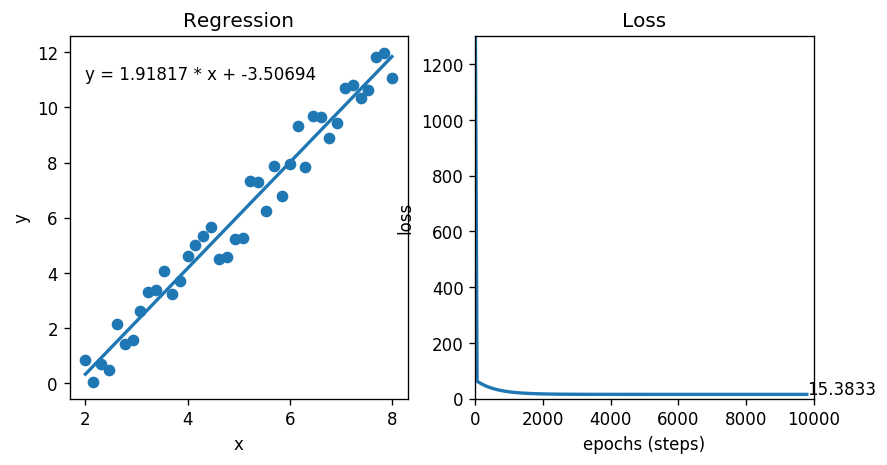

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Make a matplotlib figure with two sets of axes
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(8, 4), dpi=120)

# A convenient string generator for our equation
def regression_string(index):
    return "y = " + str(Ws[index]) + " * x + " + str(bs[index])

# Make the first axes the regression axes
regression_axis = axes[0]
regression_axis.set_title("Regression")
regression_axis.set_xlabel("x")
regression_axis.set_ylabel("y")
# Plot our actual values
regression_axis.scatter(x_vals, y_vals)
# Make an empty regression line
regression_line, = regression_axis.plot([], [], lw=2)
# Make a label for the regression line
regression_text = regression_axis.text(2, 11, regression_string(0))

# Make the second axes a plot of loss over epochs
loss_axis = axes[1]
loss_axis.set_title("Loss")
loss_axis.set_xlabel("epochs (steps)")
loss_axis.set_ylabel("loss")
# Make the graph axes ranges fit our data)
loss_axis.set_ylim([0, losses[0]])
loss_axis.set_xlim([0, steps])
# Make an empty loss line
loss_line, = loss_axis.plot([], [], lw=2)
# Make a text label for the loss value
loss_text = loss_axis.text(0, losses[0], str(losses[0]))

# An animator function, to animate our graph
def animate(frame):
    x = np.linspace(x_vals[0], x_vals[len(x_vals) - 1], 2)
    y = Ws[frame] * x + bs[frame]
    regression_line.set_data(x, y)
    loss_line.set_data(np.linspace(0, frame, frame / 50), losses[0:frame:50])
    regression_text.set_text(regression_string(frame))
    loss_text.set_x(frame)
    loss_text.set_y(losses[frame])
    loss_text.set_text(str(losses[frame]))
    return regression_line, loss_line, regression_text, loss_text

# Create the animation
anim = animation.FuncAnimation(fig, animate, frames=range(0, steps, 200), interval=100, blit=True)

# Run the animation, display it in this notebook
HTML(anim.to_html5_video())


### So... Why Machine Learning?

This method seems overkill and inefficient for doing what a graphing calculator can do in less time. But let's say that we wanted to take the same methods and start using them for more complex purposes, like fitting a plane...

In [108]:
# Make a plane of points with some noise
x_vals, y_vals, z_vals, actual_loss = generate_plane(2, -3, 4, 0.3)

import tensorflow as tf

# Setup tensors
a = tf.Variable([.3])
b = tf.Variable([.3])
c = tf.Variable([-.3])
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)
z = tf.placeholder(tf.float32)
planar = (a * x + b * y) / -c
loss = tf.reduce_sum(tf.square(planar - z))
optimizer = tf.train.GradientDescentOptimizer(0.0001).minimize(loss)


steps = 5000

losses = steps * [ 0.0 ]
a_vals = steps * [ 0.0 ]
b_vals = steps * [ 0.0 ]
c_vals = steps * [ 0.0 ]

def gradient_regression(epochs):
    global losses
    global x_vals
    global y_vals
    global z_vals
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    data = { x : x_vals.tolist(), y: y_vals.tolist(), z: z_vals.tolist() }
    for i in range(epochs):
        _, output_loss, output_a, output_b, output_c = session.run([optimizer, loss, a, b, c], feed_dict=data)
        losses[i] = output_loss
        a_vals[i] = output_a[0]
        b_vals[i] = output_b[0]
        c_vals[i] = output_c[0]

execution_time = measure_time(gradient_regression, steps)
print "Execution time:", execution_time
print "loss:", losses[steps - 1]
print "actual loss:", actual_loss

Execution time: 5.64715003967
loss: 11.7363
actual loss: 11.7636564827


### Now let's graph it

You'll notice that the number of epochs in the above code is half of what we used in the linear regression. In this case, I chose to lower the number of epochs because the loss difference between the machine learning output and the actual loss does not improve with more epochs. Let's animate this... 

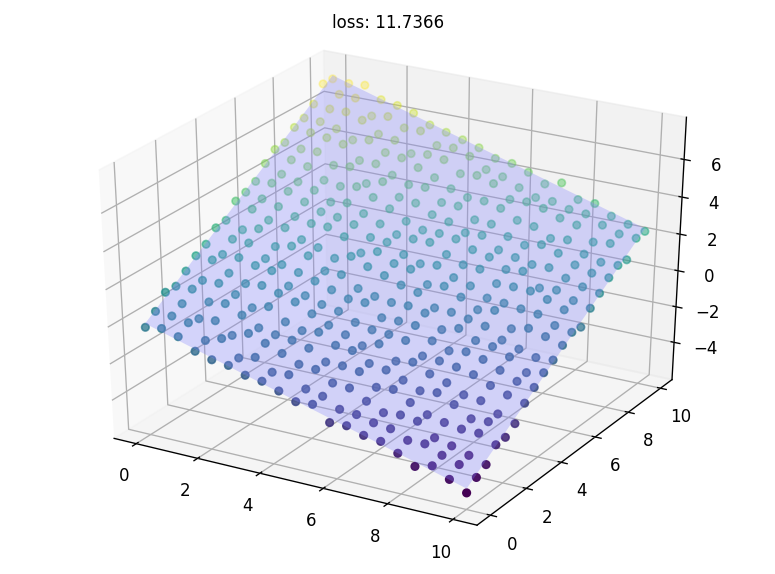

In [109]:
# Now graph it
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from mpl_toolkits.mplot3d import Axes3D
fig=plt.figure(num=None, figsize=(8, 6),dpi=120)
fig.canvas.draw()
axes = fig.add_subplot(111, projection='3d')
axes.scatter(xs=x_vals, ys=y_vals, zs=z_vals, c=z_vals, cmap=plt.cm.viridis)

def generate_verts(frame):
    corners = [ (x_coord, y_coord, (a_vals[frame] * x_coord + b_vals[frame] * y_coord) / -c_vals[steps - 1]) for x_coord, y_coord in [(0, 0), (0, 10), (10, 10), (10, 0)] ]
    xs, ys, zs = zip(*corners)
    return [zip(xs, ys, zs)]

poly = Poly3DCollection(generate_verts(0), alpha=0.3)
poly.set_facecolor([0.5, 0.5, 1])
axes.add_collection3d(poly)

loss_text = axes.text(0, 10, 10, "loss: ")

def animate(frame):
    poly.set_verts(generate_verts(frame))
    loss_text.set_text("loss: " + str(losses[frame]))
    return poly, loss_text

anim = animation.FuncAnimation(fig, animate, frames=range(0, steps, 200), interval=100, blit=True)

# Run the animation, display it in this notebook
HTML(anim.to_html5_video())



###  Can technology make it go faster?

`numpy` and it's sibling `scipy` are popular packages for working with large sets of numbers. They are extremely fast because they are written in C, built around traditional arrays. You may have wondered about some of the list operations that we perform using `numpy`. For example, if we are generating an array of `y` values with:

```
y = W * x + b
```

If the `x` array contains _*n*_ values, this single operation actually has complexity _*O(n)*_. However, we didn't include that in our overall complexity for previous algorithms simply because when we are comparing one linear regression algorithm to another, it's a performance cost that's present in all of them.

What about specialized hardware and parallelization? There are a lot of technologies that can be used to speed up these operations. Some technologies present in TACC hardware are:

##### SIMD (Single instruction, multiple data):

Most modern processors have some type of SIMD functionality built in. If you are going to multiply every element of an array by W, then SIMD allows you to multiply every element in an array simultaneously in the same time it would take to multiply a single element.

##### GPGPU (General purpose graphics processing unit):

3D graphics in video games are created with 3D polygon data. To quickly perform the matrix operations necessary to render the graphics, companies like NVIDIA created video hardware with specialized graphics processing units (GPUs) that perform these operations extremely quickly. Later on, researchers started exploiting these GPUs to perform non-graphics matrix operations (because a lot of complex mathematics can be represented with matrices.) This technology eventually becamse General Purpose GPU.

##### Parallelization:

At TACC, machines like [Stampede](https://www.tacc.utexas.edu/stampede/) are built with thousands of individual self contained computers, called nodes. Each node also contains dozens of individual processing cores. By writing code that distributes the workload between multiple nodes and cores, we can divide up a single task and perform each portion in parallel.